In [1]:
import pandas as pd
from tqdm import tqdm
import re

In [2]:
def Get_year_results(year_string, out_string):
    results = pd.read_html('https://sport.mkez.tw/games/'+ year_string +'/front/schedule_ball_score.php')[0]

    #get more pages
    for i in tqdm(range(1,150)):
        results_temp = pd.read_html('https://sport.mkez.tw/games/'+ year_string +'/front/schedule_ball_score.php?pageNum_RS=' + str(i))[0]
        #print(html_tables_temp)
        results = pd.concat([results, results_temp])
        
    results.columns = ['matchID', 'Time', 'Group', 'inGroup_matchID', 'Player1', 'Score', 'Player2', 'Ranking']
    results = results.reset_index(drop = True)

    #filtered out matches not played
    invalid_scores = ['傷', '空', '請', '棄', '-2', '-5']
    for i in invalid_scores:
        f = results['Score'].str.contains(i)
        results = results[~f]

    #get group and round columns
    results['Gr'] = results['Group'].str.replace("子組第.次賽 圖", "", regex = True)
    results['Round'] = results['Group'].str.replace("(.子組| 圖)", "", regex = True)

    #go through rows to get player-results
    player_stats = {}
    for i in results.index:
        #player 1
        Player_entry = re.sub("(\\(.+\\)|[0-9]|勝)", "", results.Player1[i])
        #flip team-player formant to player-team
        Player_name = Player_entry.split(' - ')[1].strip() + ' - ' + Player_entry.split(' - ')[0]

        #initialize selection and final appearances
        selection = '-'
        finals_app = 0

        #player 1's score is W:L
        score = results.Score[i].split(' : ')
        games_W = int(score[0])
        games_L = int(score[1])

        #three games won = 1 match won
        if games_W == 3:
            match_W = 1
            match_L = 0
            #update the selection and finals_app status for rows with 勝: 入選
            if '入選' in str(results.Ranking[i]):
                selection = results.Round[i] #+ '入選'
                finals_app = 1
        else:
            match_W = 0
            match_L = 1
            #update the finals_app status for rows with 勝: 入選
            if '入選' in str(results.Ranking[i]):
                finals_app = 1
    
        #initialize player results dict if not there yet   
        if Player_name not in player_stats.keys():
            player_stats[Player_name] = {'name': Player_name, 'Gr': results.Gr[i],
                                         'W': match_W, 'L': match_L,
                                         'g_W': games_W, 'g_L': games_L, 
                                         'selection': selection, 'finals_app': finals_app
                                        }
        else:
            #update player stats
            player_stats[Player_name]['W'] += match_W
            player_stats[Player_name]['L'] += match_L
            player_stats[Player_name]['g_W'] += games_W
            player_stats[Player_name]['g_L'] += games_L
            player_stats[Player_name]['finals_app'] += finals_app            

            if '入選' in selection:
                player_stats[Player_name]['selection'] = selection
        
        #player 2
        Player_entry = re.sub("(\\(.+\\)|[0-9]|勝)", "", results.Player2[i])
        Player_name = Player_entry.split(' - ')[1].strip() + ' - ' + Player_entry.split(' - ')[0]

        #initialize selection and final appearances
        selection = '-'
        finals_app = 0

        #player 1's score is L:W
        score = results.Score[i].split(' : ')
        games_W = int(score[1])
        games_L = int(score[0])
    
        #three games won = 1 match won
        if games_W == 3:
            match_W = 1
            match_L = 0
            #update the selection and finals_app status for rows with 勝: 入選
            if '入選' in str(results.Ranking[i]):
                selection = results.Round[i] # + '入選'
                finals_app = 1
        else:
            match_W = 0
            match_L = 1
            #update the finals_app status for rows with 勝: 入選
            if '入選' in str(results.Ranking[i]):
                finals_app = 1

        #initialize player results dict if not there yet   
        if Player_name not in player_stats.keys():
            player_stats[Player_name] = {'name': Player_name, 'Gr': results.Gr[i],
                                         'W': match_W, 'L': match_L,
                                         'g_W': games_W, 'g_L': games_L,
                                         'selection': selection, 'finals_app': finals_app
                                        }
        else:
            #update player stats
            player_stats[Player_name]['W'] += match_W
            player_stats[Player_name]['L'] += match_L
            player_stats[Player_name]['g_W'] += games_W
            player_stats[Player_name]['g_L'] += games_L
            player_stats[Player_name]['finals_app'] += finals_app            
            if '入選' in selection:
                player_stats[Player_name]['selection'] = selection

    #turn player stats dict into pd dataframe
    player_stats = pd.DataFrame.from_dict(player_stats, orient='index').reset_index(drop = True)

    #get total matches/games won and winning percentages
    player_stats['Tot'] = player_stats.W + player_stats.L
    player_stats['W_pct'] = round(player_stats.W / player_stats.Tot, 3)
    player_stats['Tot_Gms'] = player_stats.g_W + player_stats.g_L
    player_stats['g_W_pct'] = round(player_stats.g_W / player_stats.Tot_Gms, 3)

    #sort by match and then game winning pct
    player_stats = player_stats.sort_values(by=['W_pct', 'g_W_pct'], ascending = False)

    #reorder columns
    player_stats = player_stats[['name', 'Gr', 
                                 'W', 'L', 'Tot',  'W_pct', 'selection', 'finals_app',
                                 'g_W', 'g_L',  'Tot_Gms', 'g_W_pct',]]

    #mandarin column names
    player_stats.columns = ['選手姓名 - 隊名', '組', 
                                 '勝', '敗', '場',  '勝率', '入選賽次', '決選數',
                                 '勝局', '敗局',  '總局', '局勝率',]
    

    #save to tsv (+ female and male versions)
    player_stats.to_csv(out_string + '_results.tsv', sep="\t", index = False, float_format="%.3f") 
    
    player_stats_f = player_stats[player_stats['組'].str.contains('女')]
    player_stats_f.to_csv(out_string + '_results_f.tsv', sep="\t", index = False, float_format="%.3f") 
    
    player_stats_m = player_stats[player_stats['組'].str.contains('男')]
    player_stats_m.to_csv(out_string + '_results_m.tsv', sep="\t", index = False, float_format="%.3f") 

    return player_stats


In [3]:
results_112 = Get_year_results('tt_11112', '112')
results_112

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:09<00:00, 16.12it/s]


,選手姓名 - 隊名,組,勝,敗,場,勝率,入選賽次,決選數,勝局,敗局,總局,局勝率
214,李昱諄 - 國泰人壽,女,5,0,5,1.0,第一次賽,1,15,0,15,1.000
211,黎昕陽 - 第一銀行,男,6,0,6,1.0,第一次賽,1,18,3,21,0.857
213,高承睿 - 合作金庫,男,6,0,6,1.0,第一次賽,1,18,4,22,0.818
212,鄭先知 - 國泰人壽,女,5,0,5,1.0,第一次賽,1,15,5,20,0.750
208,劉馨尹 - 國泰人壽,女,9,1,10,0.9,第二次賽,2,29,6,35,0.829
...,...,...,...,...,...,...,...,...,...,...,...,...
125,鄭晴文 - 國泰人壽,女,0,6,6,0.0,-,0,1,18,19,0.053
179,陳楷庭 - 東泰高中,男,0,6,6,0.0,-,0,1,18,19,0.053
150,趙偉伯 - 彰化師大,男,0,2,2,0.0,-,0,0,6,6,0.000
161,蔡承翰 - 海山高中,男,0,4,4,0.0,-,0,0,12,12,0.000


In [4]:
results_114 = Get_year_results('tt_1131112', '114')
results_114

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:16<00:00,  8.83it/s]


,選手姓名 - 隊名,組,勝,敗,場,勝率,入選賽次,決選數,勝局,敗局,總局,局勝率
222,葉伊恬 - 合作金庫,女,6,0,6,1.0,第一次賽,1,18,3,21,0.857
221,蘇昱綸 - 合作金庫,男,6,0,6,1.0,第一次賽,1,18,4,22,0.818
220,吳映萱 - 國泰人壽,女,6,0,6,1.0,第一次賽,1,18,5,23,0.783
219,洪敬愷 - 第一銀行,男,6,0,6,1.0,第一次賽,1,18,7,25,0.720
216,黎彥君 - 第一銀行,男,9,1,10,0.9,第二次賽,1,28,10,38,0.737
...,...,...,...,...,...,...,...,...,...,...,...,...
182,李冠炫 - 香山高中,男,0,6,6,0.0,-,0,0,18,18,0.000
183,朱芫毅 - 至正國中,男,0,6,6,0.0,-,0,0,18,18,0.000
188,楊博翔 - 臺灣師大,男,0,2,2,0.0,-,0,0,6,6,0.000
192,顏瑜廷 - 個人報名,男,0,6,6,0.0,-,0,0,18,18,0.000


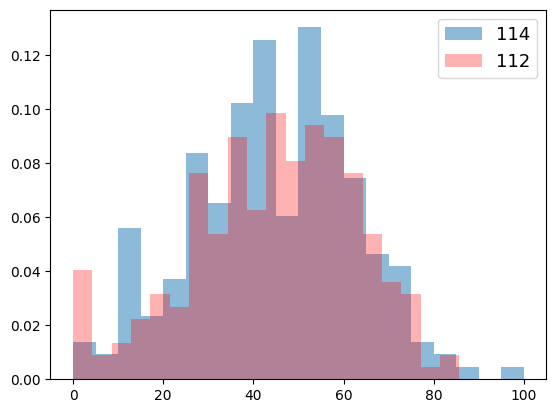

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
w_perc_112 = results_114['局勝率']*100
w_perc_114 = results_112['局勝率']*100
ax.hist(w_perc_114, alpha = 0.5, bins=20, label = "114", weights=np.ones(len(w_perc_114)) / len(w_perc_114))
ax.hist(w_perc_112, alpha = 0.3, bins=20, label = "112", color = "r", weights=np.ones(len(w_perc_112)) / len(w_perc_112))
plt.legend(loc="upper right", fontsize=13)


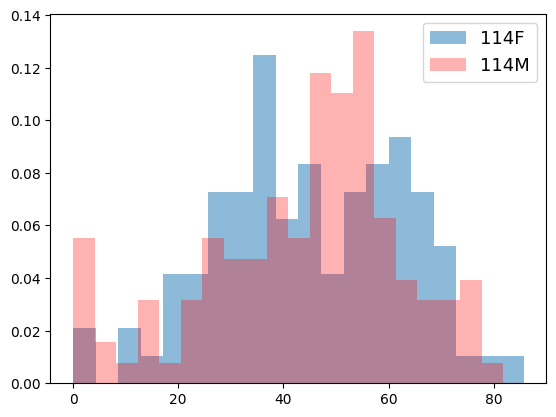

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
w_perc_114f = results_114.loc[results_114['組'] == '女', '局勝率']*100
w_perc_114m = results_114.loc[results_114['組'] == '男', '局勝率']*100
ax.hist(w_perc_114f, alpha = 0.5, bins=20, label = "114F", weights=np.ones(len(w_perc_114f)) / len(w_perc_114f))
ax.hist(w_perc_114m, alpha = 0.3, bins=20, label = "114M", color = "r", weights=np.ones(len(w_perc_114m)) / len(w_perc_114m))
plt.legend(loc="upper right", fontsize=13)

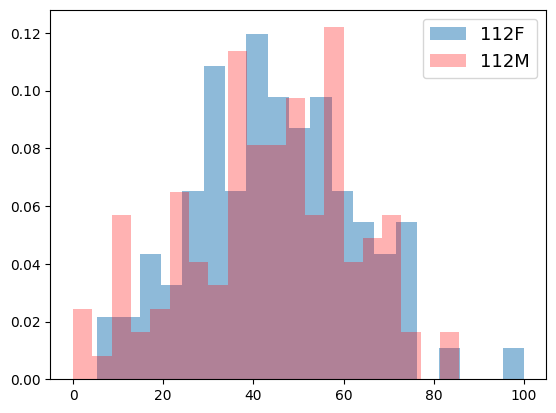

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
w_perc_112f = results_112.loc[results_112['組'] == '女', '局勝率']*100
w_perc_112m = results_112.loc[results_112['組'] == '男', '局勝率']*100
ax.hist(w_perc_112f, alpha = 0.5, bins=20, label = "112F", weights=np.ones(len(w_perc_112f)) / len(w_perc_112f))
ax.hist(w_perc_112m, alpha = 0.3, bins=20, label = "112M", color = "r", weights=np.ones(len(w_perc_112m)) / len(w_perc_112m))
plt.legend(loc="upper right", fontsize=13)